# Identificación por mínimos cuadrados recursivos

In [1]:
import control as ctrl
import numpy as np
from matplotlib import pyplot as plt

## Influencia de la excitación en la estimación

Se tiene el siguiente sistema a identificar

$$ y_k +a y_{k-1} = b u_{k-1} + e_{k} $$

Que puede factorizarse de la siguiente manera 

$$ y_k = -a y_{k-1} + b u_{k-1} + e_{k} $$
$$ y_k = \varphi_{k}^\top \theta  + e_{k} $$
con
$$ \varphi_k = [-y_{k-1}, u_{k-1}]$$
$$ \theta = [a , b ]$$


In [144]:
# Parámetros verdaderos
a, b, c = -0.8, 0.5, 0.0
def obtener_datos(u,e,A=a,B=b,C=0):
    N = len(u)
    y = np.zeros_like(u)
    for k in range(1, N):  
        y[k] = -A*y[k-1] + B*u[k-1] + e[k] + C*e[k-1] # c=0

    return y

In [146]:
# Estimador por mínimos cuadrados recursivo para un modelo ARX
def estimador_RLS(u,y,na=1, nb=1,lambda_=1,theta_real=None,plot=True):
    N = len(u)
    theta_hat = np.zeros(na+nb)       # estimación inicial [a_hat, b_hat]
    P = 100 * np.eye(na+nb)          # matriz de covarianza grande
    err = np.zeros_like(y)

    theta_hist = []    
    k_range = range(na+1, N)
    for k in k_range:
        phi = np.concatenate((-y[k-1:k-na-1:-1], u[k-1:k-nb-1:-1]))   # vector de regresores
        y_hat = phi @ theta_hat
        err[k] = y[k] - y_hat

        K = P @ phi / (lambda_ + phi.T @ P @ phi)
        theta_hat = theta_hat + K * err[k]
        P = (P - np.outer(K, phi) @ P) / lambda_

        theta_hist.append(theta_hat.copy())

    theta_hist = np.array(theta_hist)

    if plot:
        plt.subplot(211)        
        plt.step(k_range,err[k_range],where='post')
        #plt.xlabel('Tiempo [s]')
        plt.ylabel('Error de predicción')
        plt.subplot(212)
        for idx_na in range(0,na):
            plt.step(k_range,theta_hist[:,idx_na], label=f"$\\hat{{a_{idx_na+1}}}$",where='post')
        for idx_nb in range(0,nb):
            plt.step(k_range,theta_hist[:,na+idx_nb], label=f"$\\hat{{b_{idx_nb+1}}}$",where='post')
        if theta_real!=None:
            colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
            for idx_na in range(na):
                color = colors[idx_na % len(colors)]
                plt.axhline(theta_real[idx_na], linestyle='--', color=color, label=f"$a_{idx_na}$")
            for idx_nb in range(nb):
                color = colors[(idx_nb+na) % len(colors)]
                plt.axhline(theta_real[idx_nb+na], linestyle='--', color=color, label=f"$b_{idx_nb}$")            
        plt.legend()
        plt.xlabel('k')
        plt.ylabel('$\\theta$')
        plt.show()

        # Observemos la correlación del error de predicción
        N_lag = 50
        ree = np.correlate(err,err,'full')
        lags = np.arange(-len(err)+1, len(err))
        center = len(ree) // 2
        ree = ree[center-N_lag:center+N_lag+1]
        lags_plot = lags[center-N_lag:center+N_lag+1]

        #Pee = np.fft.fft(ree)
        #w = np.fft.fftfreq(N, 1)*2*np.pi 
        plt.figure()
        #plt.subplot(211)
        plt.plot(lags_plot,ree)
        plt.ylabel('$r_{{ee}}$')
        plt.xlabel('lag')
        #plt.subplot(212)
        #plt.plot(w,Pee)
        #plt.ylabel('$S_{{ee}}$')
        #plt.xlabel('$\\omega_r [rad]$')
        plt.show()
    return theta_hist[-1,:],P


### Ensayo 1: entrada pulso

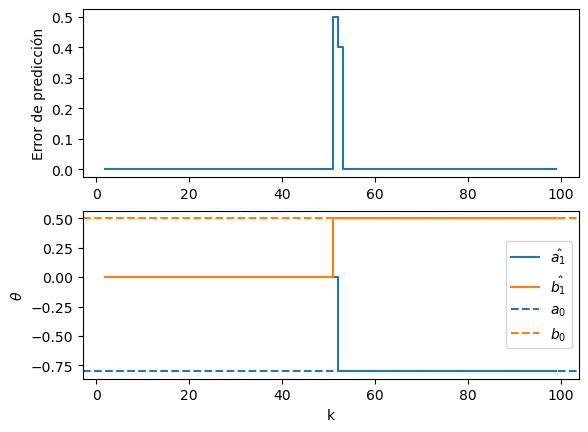

Theta estimado = [-0.79923743  0.49961557]


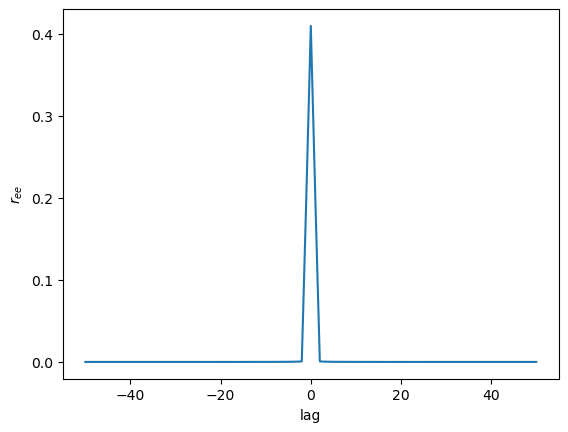

In [129]:
N = 100
u = np.zeros(N)
# Ver qué pasa si modifico la amplitud!
u[50] = 1
e = np.zeros_like(u)
y = obtener_datos(u,e)

theta_hat,_ = estimador_RLS(u,y,lambda_=0.95,na=1,nb=1, theta_real=[a,b])
print(f"Theta estimado = {theta_hat}")

### Ensayo 2: entrada pulso + ruido (modelo ARX)

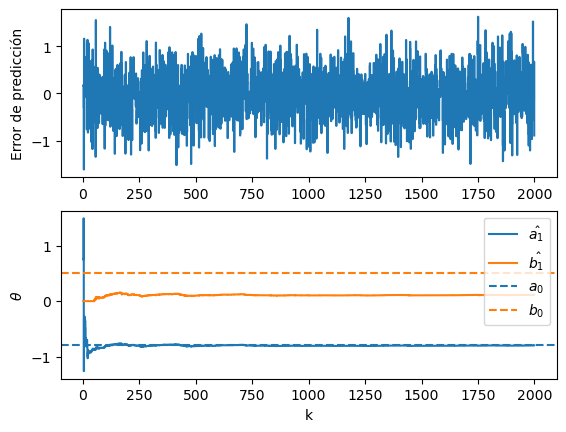

Theta estimado = [-0.79925878  0.11313955]
Desvío de la estimación = [0.01318032 0.49773126]


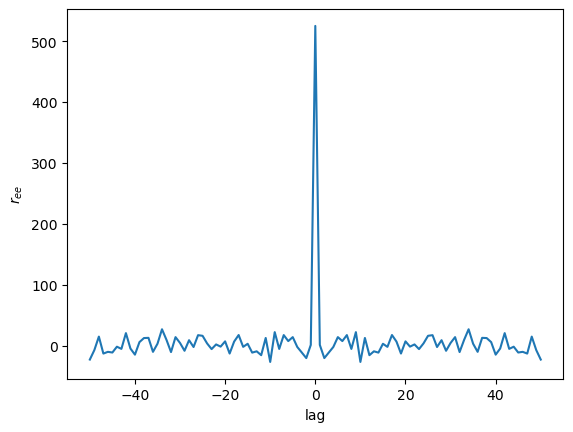

In [131]:
N = 2000
u = np.zeros(N)
# Ver qué pasa si modifico la amplitud!
u[50] = 1
sigma_e = 0.5
e = sigma_e*np.random.randn(N)
y = obtener_datos(u,e)

theta_hat,P = estimador_RLS(u,y,lambda_=1,na=1,nb=1, theta_real=[a,b])
print(f"Theta estimado = {theta_hat}")
print(f"Desvío de la estimación = {sigma_e*np.sqrt(P.diagonal().flatten())}")

# ¿Cómo es que puedo identificar bien a, pero b no?
# Ver qué pasa si u es 0

### Ensayo 3: entrada tren de pulsos + ruido (modelo ARX)

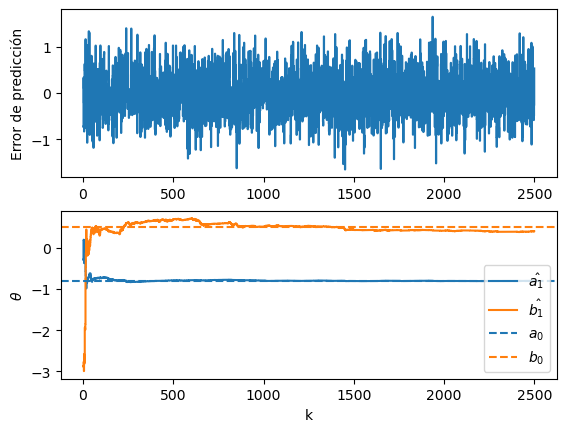

Theta estimado = [-0.79892538  0.40358614]
Desvío de la estimación = [0.01208509 0.0730795 ]


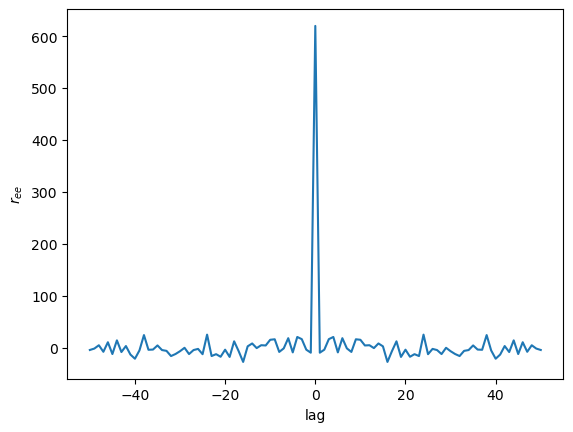

In [132]:
from scipy import signal

N = 2500
t = np.arange(N)
u = 0.1 * (signal.square(2*np.pi * t / 200, duty=0.5) + 1) 

sigma_e = 0.5
e = sigma_e*np.random.randn(N)
y = obtener_datos(u,e)

theta_hat,P = estimador_RLS(u,y,lambda_=1,na=1,nb=1, theta_real=[a,b])
print(f"Theta estimado = {theta_hat}")
print(f"Desvío de la estimación = {sigma_e*np.sqrt(P.diagonal().flatten())}")

### Ensayo 4: entrada PRBS + ruido (ARX)

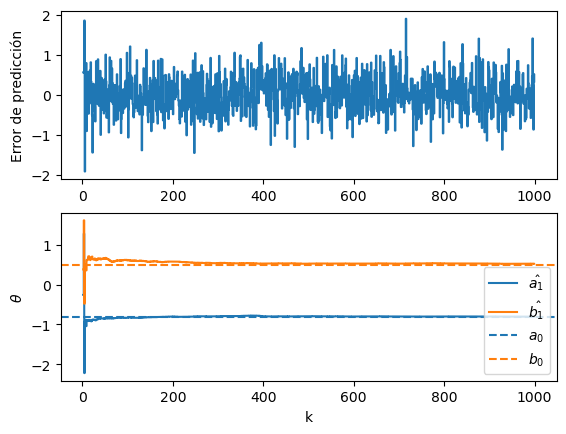

Theta estimado = [-0.80298874  0.52251672]
Desvío de la estimación = [0.01323292 0.01582715]


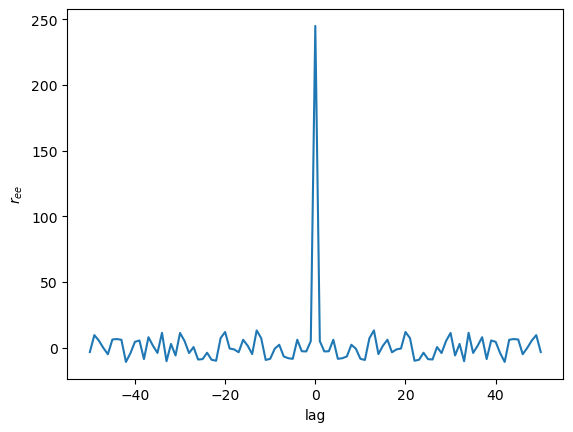

In [133]:
N = 1000
t = np.arange(N)
u = np.sign(np.random.randn(N))

sigma_e = 0.5
e = sigma_e*np.random.randn(N)
y = obtener_datos(u,e)

theta_hat,P = estimador_RLS(u,y,lambda_=1,na=1,nb=1, theta_real=[a,b])
print(f"Theta estimado = {theta_hat}")
print(f"Desvío de la estimación = {sigma_e*np.sqrt(P.diagonal().flatten())}")

## Influencia de la estructura del modelo

entrada PRBS + ruido coloreado

Observar que al usar RLS pensando que el modelo es ARX y el ruido es blanco, se comete un error en la estimación.
Si miramos solamente el desvío del estimador, pensamos que alcanzó una buena estimación. Claramente esto no es correcto porque difiere mucho del valor verdadero.

Un indicio de este problema lo muestra la gráfica de correlación del error de estimación. Se ve cierto grado de correlación lo que implica que los datos todavía tienen más información para extraer

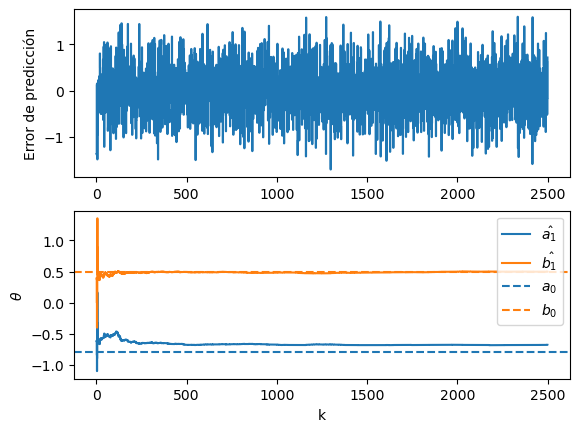

Theta estimado = [-0.6787973   0.49706474]
Desvío de la estimación = [0.01023709 0.01000645]


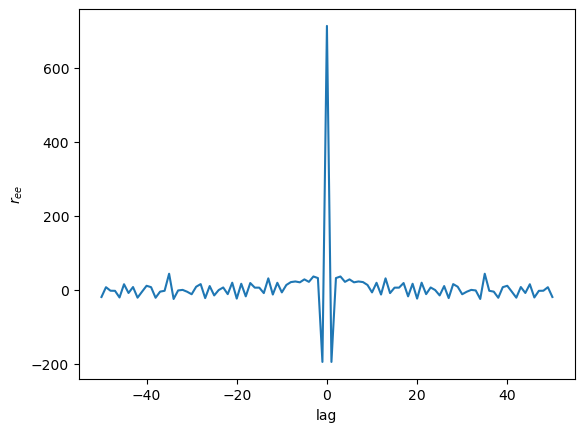

In [134]:
N = 2500
t = np.arange(N)
u = np.sign(np.random.randn(N))

sigma_e = 0.5
e = sigma_e*np.random.randn(N)
y = obtener_datos(u,e,C=-0.5)

theta_hat,P = estimador_RLS(u,y,lambda_=1,na=1,nb=1, theta_real=[a,b])
print(f"Theta estimado = {theta_hat}")
print(f"Desvío de la estimación = {sigma_e*np.sqrt(P.diagonal().flatten())}")

### Modelos estocásticos

Para solucionar el problema visto en el ensayo anterior se puede incorporar el modelo del ruido a la identificación.

Consideremos el modelo a identificar:
$$A(q) y_k = B(q) u_k + C(q) e_k$$

con $\{e_k\}$ ruido blanco.

No podemos transformar este modelo a uno de regresión, porque no conocemos $e_k$, entonces no tendríamos forma de incorporarlo al regresor $\varphi_k$.

Si embargo nos podemos valer del error de predicción $\epsilon_k = y_k - \varphi_{k-1} \hat{\theta}_{k-1}$ para aproximar $e_k$

Resulta:
$$\varphi_k =[-y_{k-1}, \dots,-y_{k-n_a}, u_{k-1},\dots,u_{k-n_b},\epsilon_{k-1},\dots,\epsilon_{k-n_c} ] $$
$$\theta = [a_1, \dots, a_{n_a}, b_1, \dots, b_{n_b},c_1,\dots, c_{n_c}]$$

In [139]:
# Estimador por mínimos cuadrados extendido para un modelo ARX con ruido coloreado
def estimador_ELS(u,y,na=1, nb=1, nc=1, lambda_=1,theta_real=None,plot=True):
    N = len(u)
    theta_hat = np.zeros(na+nb+nc)       # estimación inicial [a_hat, b_hat]
    P = 100 * np.eye(na+nb+nc)          # matriz de covarianza grande
    err = np.zeros_like(y)

    theta_hist = []    
    k_range = range(na+1, N)
    for k in k_range:
        phi = np.concatenate((-y[k-1:k-na-1:-1], u[k-1:k-nb-1:-1], err[k-1:k-nc-1:-1]))   # vector de regresores
        y_hat = phi @ theta_hat
        err[k] = y[k] - y_hat

        K = P @ phi / (lambda_ + phi.T @ P @ phi)
        theta_hat = theta_hat + K * err[k]
        P = (P - np.outer(K, phi) @ P) / lambda_

        theta_hist.append(theta_hat.copy())

    theta_hist = np.array(theta_hist)

    if plot:
        plt.subplot(211)        
        plt.step(k_range,err[k_range],where='post')
        #plt.xlabel('Tiempo [s]')
        plt.ylabel('Error de predicción')
        plt.subplot(212)
        for idx_na in range(0,na):
            plt.step(k_range,theta_hist[:,idx_na], label=f"$\\hat{{a_{idx_na+1}}}$",where='post')
        for idx_nb in range(0,nb):
            plt.step(k_range,theta_hist[:,na+idx_nb], label=f"$\\hat{{b_{idx_nb+1}}}$",where='post')
        for idx_nc in range(0,nc):
            plt.step(k_range,theta_hist[:,na+nb+idx_nc], label=f"$\\hat{{c_{idx_nc+1}}}$",where='post')
        if theta_real!=None:
            colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
            for idx_na in range(na):
                color = colors[idx_na % len(colors)]
                plt.axhline(theta_real[idx_na], linestyle='--', color=color, label=f"$a_{idx_na}$")
            for idx_nb in range(nb):
                color = colors[(idx_nb+na) % len(colors)]
                plt.axhline(theta_real[idx_nb+na], linestyle='--', color=color, label=f"$b_{idx_nb}$")            
            for idx_nc in range(nc):
                color = colors[(idx_nc+na+nb) % len(colors)]
                plt.axhline(theta_real[idx_nc+na+nb], linestyle='--', color=color, label=f"$c_{idx_nc}$")            
        plt.legend()
        plt.xlabel('k')
        plt.ylabel('$\\theta$')
        plt.show()

        # Observemos la correlación del error de predicción
        N_lag = 50
        ree = np.correlate(err,err,'full')
        lags = np.arange(-len(err)+1, len(err))
        center = len(ree) // 2
        ree = ree[center-N_lag:center+N_lag+1]
        lags_plot = lags[center-N_lag:center+N_lag+1]

        #Pee = np.fft.fft(ree)
        #w = np.fft.fftfreq(N, 1)*2*np.pi 
        plt.figure()
        #plt.subplot(211)
        plt.plot(lags_plot,ree)
        plt.ylabel('$r_{{ee}}$')
        plt.xlabel('lag')
        #plt.subplot(212)
        #plt.plot(w,Pee)
        #plt.ylabel('$S_{{ee}}$')
        #plt.xlabel('$\\omega_r [rad]$')
    return theta_hist[-1,:],P


### Repetimos ensayo anterior pero usando ELS

En este caso vemos que el residuo no queda autocorrelacionado

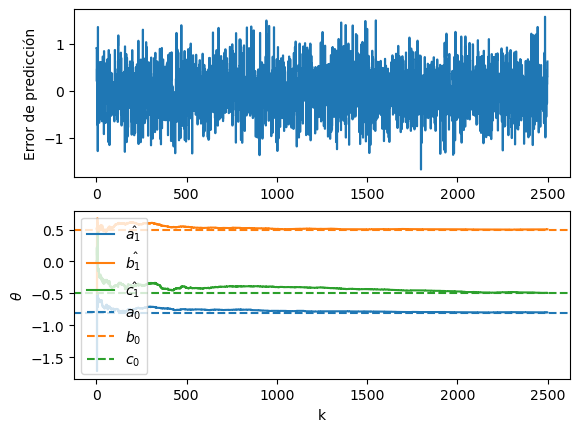

Theta estimado = [-0.79615249  0.50265699 -0.49152944]
Desvío de la estimación = [0.01120202 0.01000829 0.02295029]


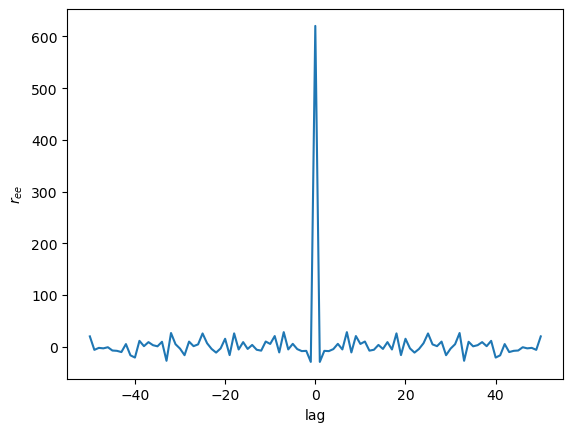

In [143]:
N = 2500
t = np.arange(N)
u = np.sign(np.random.randn(N))

sigma_e = 0.5
e = sigma_e*np.random.randn(N)
c = -0.5
y = obtener_datos(u,e,C=c)

theta_hat,P = estimador_ELS(u,y,lambda_=1,na=1,nb=1,nc=1, theta_real=[a,b,c])
print(f"Theta estimado = {theta_hat}")
print(f"Desvío de la estimación = {sigma_e*np.sqrt(P.diagonal().flatten())}")

## Estimación a lazo cerrado

La identificabilidad de un sistema se puede perder cuando las señales de entrada son combinaciones lineales de la salida.

Se proponen las siguientes leyes de control:
- $u_k=-0.2y_{k}$
- $u_k=-0.32y_{k-1}$

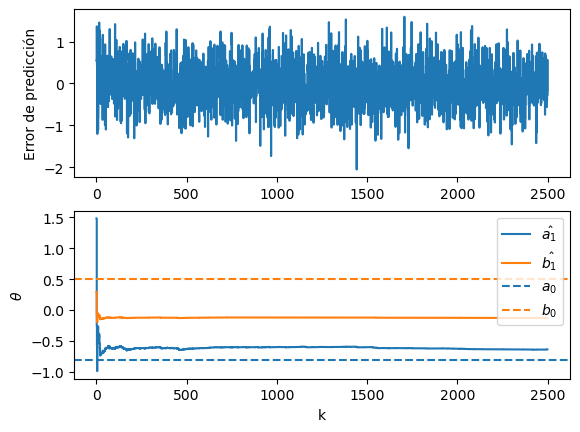

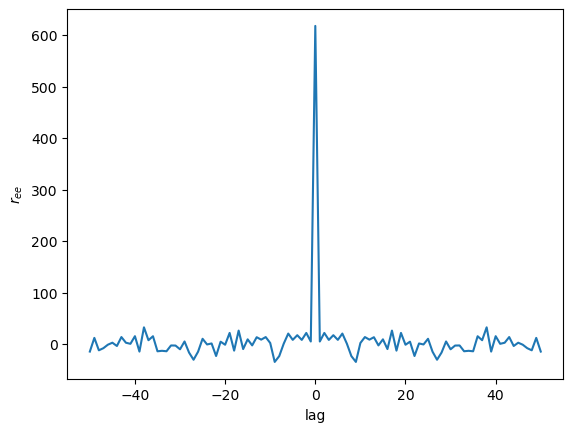

Theta estimado = [-0.63877864 -0.12775573]
Desvío de la estimación = [0.98068803 4.90290424]


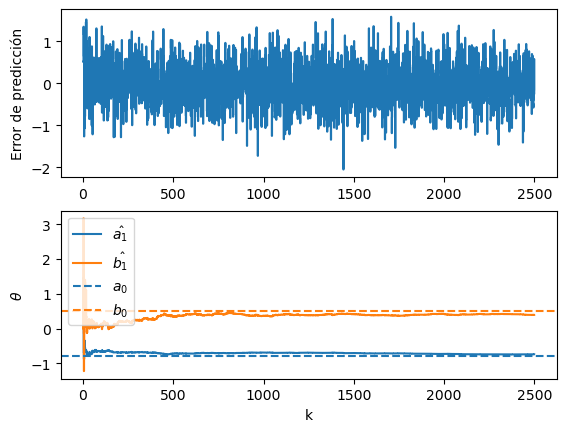

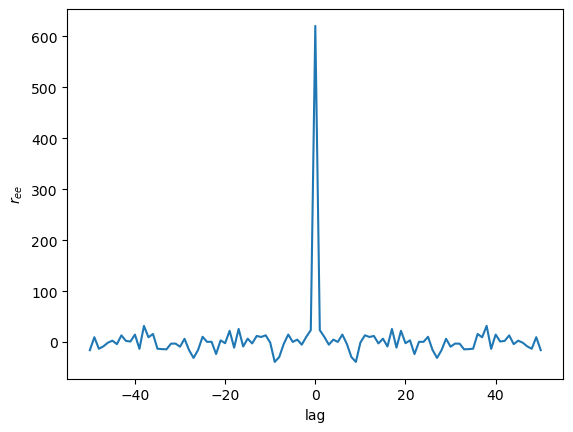

Theta estimado = [-0.7420009   0.39375071]
Desvío de la estimación = [0.02003987 0.06262357]


In [147]:
N = 2500
t = np.arange(N)
u = np.sign(np.random.randn(N))

sigma_e = 0.5
e = sigma_e*np.random.randn(N)

y1 = np.zeros_like(u)
y2 = np.zeros_like(u)
u1 = np.zeros_like(u)
u2 = np.zeros_like(u)
for k in range(1, N):  
    y1[k] = -a*y1[k-1] + b*u1[k-1] + e[k] 
    u1[k] = -0.2*y1[k] 
    y2[k] = -a*y2[k-1] + b*u2[k-1] + e[k] 
    u2[k] = -0.32*y2[k-1] 

theta_hat,P = estimador_RLS(u1,y1,lambda_=1,na=1,nb=1, theta_real=[a,b])
print(f"Theta estimado = {theta_hat}")
print(f"Desvío de la estimación = {sigma_e*np.sqrt(P.diagonal().flatten())}")

theta_hat,P = estimador_RLS(u2,y2,lambda_=1,na=1,nb=1, theta_real=[a,b])
print(f"Theta estimado = {theta_hat}")
print(f"Desvío de la estimación = {sigma_e*np.sqrt(P.diagonal().flatten())}")